# Tune rudder PID controller
We assume a thrust tuning factor of 0.03, a constant for all sea states. Without a thurst tuning factor the wave glider will experiance large thrusts for high sea states and the simulation will fail. Through the following experiments we identify:
1. The optimal gain terms for the controller,
2. The optimal proximity margin to be used along with this controller to achive path following using a series of waypoints.

In [1]:
import pathlib
import sys
module_dir = pathlib.Path("").parent.resolve()
root_dir = module_dir.parent
source_dir = root_dir.joinpath("source")
asvlite_wrapper_dir = root_dir.joinpath("dependency", "ASVLite", "wrapper", "cython")
sys.path.insert(0, str(asvlite_wrapper_dir))
sys.path.insert(0, str(source_dir))

In [2]:
import glob
import math
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pyproj
import epsg
import ctypes
from tqdm import tqdm 
from datetime import datetime, timedelta
from rudder_controller import Rudder_PID_controller
from sea_surface import py_Sea_surface
from asv import py_Asv_specification, py_Asv
from geometry import py_Coordinates_3D

## Controller tuning results

In [3]:
rudder_tuning_results_dir = root_dir.joinpath("results", "rudder_controller", "tuning")
dfs = pd.DataFrame(columns="repeats P I D error_avg error_std".split())
i = 0
for file in glob.glob(str(rudder_tuning_results_dir)+"/*.txt"):
    df = pd.read_csv(file, header=0, names="P I D error_avg error_std".split(), sep=" ")
    for j in range(len(df)):
        dfs.loc[len(dfs)] = [i, df.loc[j, "P"], df.loc[j, "I"], df.loc[j, "D"], df.loc[j, "error_avg"], df.loc[j, "error_std"]]
    i += 1

pd.set_option('display.max_rows', dfs.shape[0]+1)
dfs

,repeats,P,I,D,error_avg,error_std
0,0.0,1.00,1.00,1.00,1.154301,7.886447e-06
1,0.0,1.25,1.25,0.75,1.154293,2.738612e-06
2,0.0,1.50,1.50,1.00,1.154290,1.157383e-06
3,0.0,1.75,1.75,1.25,1.154289,5.526281e-07
4,0.0,2.00,2.00,1.50,1.154288,3.048430e-07
5,0.0,2.25,2.25,1.75,1.154288,1.828849e-07
6,0.0,2.50,2.50,2.00,1.154287,1.196170e-07
7,0.0,2.75,2.75,2.25,1.154287,7.138501e-08
8,0.0,3.00,3.00,2.50,1.154287,4.547093e-08
9,0.0,3.25,3.25,2.75,1.154287,3.529982e-08


<Axes: title={'center': 'error_avg'}, xlabel='repeats'>

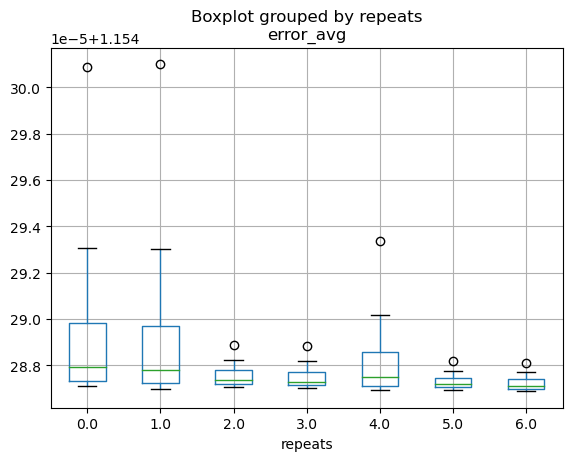

In [4]:
dfs.boxplot("error_avg", by="repeats")

In [5]:
# Find the PID for which the lowest error value was observed.
min_index = dfs["error_avg"].idxmin()
K = (dfs.loc[min_index, "P"], dfs.loc[min_index, "I"], dfs.loc[min_index, "D"])
error = dfs.loc[min_index, "error_avg"]
print(error, K)

1.1542868781644922 (4.25, 3.5, 4.25)


## Wave glider waypoint navigation using tuned controller.

In [6]:
# Output directory
output_dir = root_dir.joinpath("results", "rudder_controller", "path_following")
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True) # Create the directory if it does not exist

In [7]:
# Waypoints
waypoints = [
    py_Coordinates_3D(900.00, 1000.0), #[0]
    py_Coordinates_3D(900.00, 1100.0), #[1]
    py_Coordinates_3D(1000.0, 1100.0), #[2] 
    py_Coordinates_3D(1000.0, 1000.0), #[3]
    py_Coordinates_3D(1100.0, 1000.0), #[4]
    py_Coordinates_3D(1100.0, 1100.0), #[5] 
]

In [8]:
def get_wave_data_at(longitude, latitude):
    sig_wave_ht = None
    wave_heading = None
    if longitude <= 950.0:
        if latitude <= 1050.0:
            sig_wave_ht  = 1.5
            wave_heading = 30
        else:
            sig_wave_ht  = 4.8
            wave_heading = 120
    elif 950.0 < longitude <= 1050.0:
        if latitude <= 1050.0:
            sig_wave_ht  = 2.5
            wave_heading = 60
        else:
            sig_wave_ht  = 5.6
            wave_heading = 75
    else:
        if latitude <= 1050.0:
            sig_wave_ht  = 3.2
            wave_heading = 90
        else:
            sig_wave_ht  = 1.8
            wave_heading = 50
    return (sig_wave_ht, wave_heading)

In [9]:
# Wave glider specs
asv_spec = py_Asv_specification()
asv_spec.L_wl       = 2.1 # m
asv_spec.B_wl       = 0.6 # m
asv_spec.D          = 0.25 # m 
asv_spec.T          = 0.09 # m
asv_spec.max_speed  = 4.0 # m/s
asv_spec.disp       = 0.09 # m3
asv_spec.r_roll     = 0.2 # m
asv_spec.r_pitch    = 0.6 # m
asv_spec.r_yaw      = 0.6 # m
asv_spec.cog        = py_Coordinates_3D(1.05, 0.0, -3.0) # m

In [10]:
# Time
time_step_size = 40.0 # Simulation time step size in milliseconds

In [11]:
# Start attitude
start_attitude = py_Coordinates_3D(0.0, 0.0, 0.0) 

In [12]:
# Sea surface
wave_rand_seed = 7
count_component_waves = 21
wave_hs, wave_dp = get_wave_data_at(waypoints[0].x, waypoints[0].y) 
sea_surface = py_Sea_surface(wave_hs, wave_dp, wave_rand_seed, count_component_waves)

In [13]:
# Initialise the wave glider
asv = py_Asv(asv_spec, sea_surface, waypoints[0], start_attitude)
thrust_tuning_factor = 0.03
# Set thrust tuning factor
asv.py_wg_set_thrust_tuning_factor(thrust_tuning_factor)

In [14]:
# Initialise the rudder controller
rudder_controller   = Rudder_PID_controller(asv_spec, K) 
rudder_angle = 0.0

In [15]:
# Simulate till last waypoint
proximity_margin = 15.0 # m
i_waypoint = 0
simulated_path = []
time = datetime.now()
time_step_size = 40.0 # Simulation time step size in milliseconds

# Show a progress bar
pbar = tqdm(total = len(waypoints))
pbar.set_description("Simulation progress")

# Simulate till last waypoint
has_not_reached_final_waypoint = True
while True:
    # Increment time
    time = time + timedelta(seconds=time_step_size/1000.0)
    # Check if reached the waypoint  
    position = asv.py_get_position_cog() # Get the current position in PCS.
    simulated_path.append(position)
    dx = position.x - waypoints[i_waypoint].x 
    dy = position.y - waypoints[i_waypoint].y 
    distance = math.sqrt(dx*dx + dy*dy) # m
    if distance <= proximity_margin:
        # Reached current waypoint
        pbar.update(1)
        df.loc[i_waypoint+1, "Timestamp(simulated)"] = time
        # Increment to next waypoint 
        if i_waypoint == len(waypoints)-1: 
            # Reached the final waypoint
            break
        else:
            i_waypoint += 1
    # Get the sea state
    new_hs, new_dp = get_wave_data_at(position.x, position.y)
    if new_hs == None or new_dp == None:
        print("{}: Wave data not available.".format(time))
        break
    # Compare the sea state with the current sea state
    current_hs = sea_surface.py_get_significant_height() # m
    current_dp = sea_surface.py_get_predominant_heading() # radians
    is_sea_state_same = (float(new_hs) == float(current_hs) and float(new_dp == current_dp))
    # If the sea state has changed then, set the new sea state in the wave glider
    if not is_sea_state_same:
        new_sea_surface = py_Sea_surface(new_hs, new_dp, wave_rand_seed, count_component_waves)
        asv.py_set_sea_state(new_sea_surface)    
        asv.py_wg_set_thrust_tuning_factor(thrust_tuning_factor)                
    # Set rudder angle
    rudder_angle = rudder_controller.get_rudder_angle(asv, waypoints[i_waypoint])
    # Compute dynamics
    try:
        asv.py_wg_compute_dynamics(rudder_angle, time_step_size)
    except Exception as e:
        print(str(e))

pbar.close()

# Write simulated data to file
f = open(str(output_dir)+"/path.txt", "w")
f.write("x, y\n")
for position in simulated_path:
    f.write("{} {}\n".format(position.x, position.y))
f.close()

Simulation progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.85it/s]


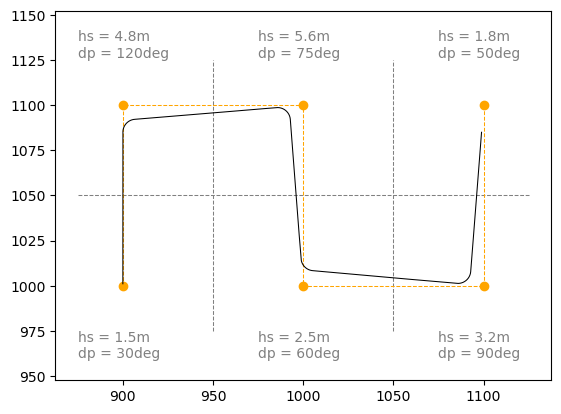

In [16]:
# Plot the grid
plt.plot([950, 950], [975, 1125], color='grey', linestyle='--', linewidth=0.75)
plt.plot([1050, 1050], [975, 1125], color='grey', linestyle='--', linewidth=0.75)
plt.plot([875, 1125], [1050, 1050], color='grey', linestyle='--', linewidth=0.75)
# Plot the sea states
plt.text(875, 1125, "hs = 4.8m\ndp = 120deg", color="grey", ha='left', va='bottom')
plt.text(975, 1125, "hs = 5.6m\ndp = 75deg", color="grey", ha='left', va='bottom')
plt.text(1075, 1125, "hs = 1.8m\ndp = 50deg", color="grey", ha='left', va='bottom')
plt.text(875, 975, "hs = 1.5m\ndp = 30deg", color="grey", ha='left', va='top')
plt.text(975, 975, "hs = 2.5m\ndp = 60deg", color="grey", ha='left', va='top')
plt.text(1075, 975, "hs = 3.2m\ndp = 90deg", color="grey", ha='left', va='top')
# Plot waypoints
xs = [point.x for point in waypoints]
ys  = [point.y for point in waypoints]
sc = plt.scatter(x=xs, y=ys, color="orange")
# Plot desired path
plt.plot(xs, ys, color='orange', linestyle='--', linewidth=0.75)
# Plot simulated path
xs = [point.x for point in simulated_path]
ys  = [point.y for point in simulated_path]
plt.plot(xs, ys, color='black', linewidth=0.75)
plt.axis("equal")
# plt.show()
plot_path_file = output_dir.joinpath("grid_world.png")
plt.savefig(str(plot_path_file), dpi=300)

### Observations
The proximity margin used for the simulation should be carefully selected in relation to the magnitude of the turning moment that the vehicle can generate. When the proximity margin is set too small, the controller sometimes finds it difficult to make efficient turns. Also, if the vehicles can generate larger turning moments, it is possible to make the proximity margin smaller. It could be that a larger turning moment implies a smaller turning radius and therefore facilitates a smaller proximity margin.

The simulation below shows the undesired result when the proximity margin is set too small. 

In [17]:
asv = py_Asv(asv_spec, sea_surface, waypoints[0], start_attitude)

# Simulate till last waypoint
proximity_margin = 5.0 # m
i_waypoint = 0
simulated_path = []
time = datetime.now()
time_step_size = 40.0 # Simulation time step size in milliseconds

# Show a progress bar
pbar = tqdm(total = len(waypoints))
pbar.set_description("Simulation progress")

# Simulate till last waypoint
has_not_reached_final_waypoint = True
while True:
    # Increment time
    time = time + timedelta(seconds=time_step_size/1000.0)
    # Check if reached the waypoint  
    position = asv.py_get_position_cog() # Get the current position in PCS.
    simulated_path.append(position)
    dx = position.x - waypoints[i_waypoint].x 
    dy = position.y - waypoints[i_waypoint].y 
    distance = math.sqrt(dx*dx + dy*dy) # m
    if distance <= proximity_margin:
        # Reached current waypoint
        pbar.update(1)
        df.loc[i_waypoint+1, "Timestamp(simulated)"] = time
        # Increment to next waypoint 
        if i_waypoint == len(waypoints)-1: 
            # Reached the final waypoint
            break
        else:
            i_waypoint += 1
    # Get the sea state
    new_hs, new_dp = get_wave_data_at(position.x, position.y)
    if new_hs == None or new_dp == None:
        print("{}: Wave data not available.".format(time))
        break
    # Compare the sea state with the current sea state
    current_hs = sea_surface.py_get_significant_height() # m
    current_dp = sea_surface.py_get_predominant_heading() # radians
    is_sea_state_same = (float(new_hs) == float(current_hs) and float(new_dp == current_dp))
    # If the sea state has changed then, set the new sea state in the wave glider
    if not is_sea_state_same:
        new_sea_surface = py_Sea_surface(new_hs, new_dp, wave_rand_seed, count_component_waves)
        asv.py_set_sea_state(new_sea_surface)    
        asv.py_wg_set_thrust_tuning_factor(thrust_tuning_factor)                
    # Set rudder angle
    rudder_angle = rudder_controller.get_rudder_angle(asv, waypoints[i_waypoint])
    # Compute dynamics
    try:
        asv.py_wg_compute_dynamics(rudder_angle, time_step_size)
    except Exception as e:
        print(str(e))

pbar.close()

Simulation progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  4.11s/it]


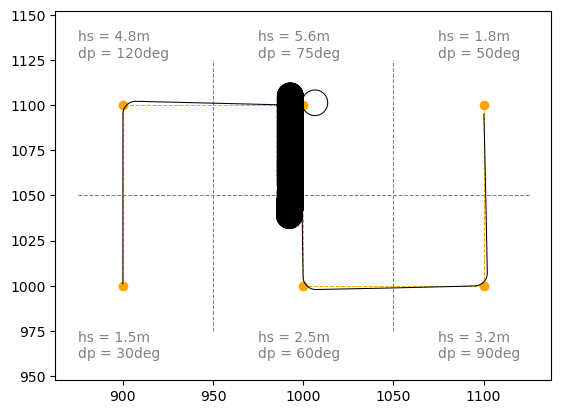

In [18]:
# Plot the grid
plt.plot([950, 950], [975, 1125], color='grey', linestyle='--', linewidth=0.75)
plt.plot([1050, 1050], [975, 1125], color='grey', linestyle='--', linewidth=0.75)
plt.plot([875, 1125], [1050, 1050], color='grey', linestyle='--', linewidth=0.75)
# Plot the sea states
plt.text(875, 1125, "hs = 4.8m\ndp = 120deg", color="grey", ha='left', va='bottom')
plt.text(975, 1125, "hs = 5.6m\ndp = 75deg", color="grey", ha='left', va='bottom')
plt.text(1075, 1125, "hs = 1.8m\ndp = 50deg", color="grey", ha='left', va='bottom')
plt.text(875, 975, "hs = 1.5m\ndp = 30deg", color="grey", ha='left', va='top')
plt.text(975, 975, "hs = 2.5m\ndp = 60deg", color="grey", ha='left', va='top')
plt.text(1075, 975, "hs = 3.2m\ndp = 90deg", color="grey", ha='left', va='top')
# Plot waypoints
xs = [point.x for point in waypoints]
ys  = [point.y for point in waypoints]
sc = plt.scatter(x=xs, y=ys, color="orange")
# Plot desired path
plt.plot(xs, ys, color='orange', linestyle='--', linewidth=0.75)
# Plot simulated path
xs = [point.x for point in simulated_path]
ys  = [point.y for point in simulated_path]
plt.plot(xs, ys, color='black', linewidth=0.75)
plt.axis("equal")
plt.show()

## Conclusion

In [19]:
# Optimal PID
print("Optimal K = {}".format(K))
# Optimal proximity margin
print("Optimal proximity margin = {} m".format(proximity_margin))

Optimal K = (4.25, 3.5, 4.25)
Optimal proximity margin = 5.0 m
